Copied from here:
https://github.com/gisbi-kim/symforce-tutorials/blob/main/pgo/1_pgo3d_toy/pose_graph_opt_3d_toy.ipynb


In [22]:
import os 
import copy 
import numpy as np
np.set_printoptions(suppress=True, precision=3)

from scipy.spatial.transform import Rotation as R

import symforce 
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")
from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values
from symforce import typing as sfT

%matplotlib inline
import matplotlib.pyplot as plt

import gtsam
from gtsam.utils import plot

symforce uses symengine as backend


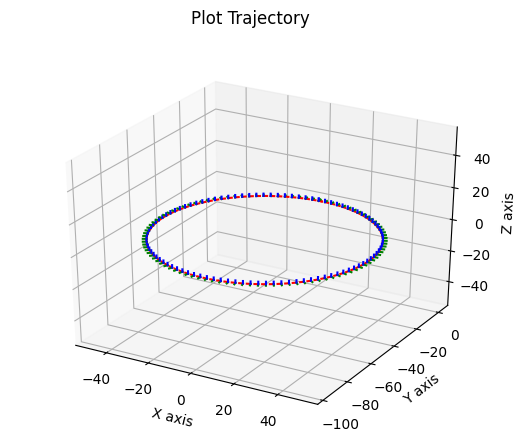

In [23]:
### generate a mini graph having N poses

# helper funcs 
def move(prev_pose, x_meter=1.0, yaw_deg=90):
    # input: assume prev_pose is 4x4 SE(3) matrix 
    # output: SE(3), the moved (transformed) pose 

    def rpy2mat(rpy, deg=True):
        return R.from_euler('xyz', rpy, degrees=deg).as_matrix()

    def movement():
        movement_yaw = yaw_deg # deg, means turn left
        movement_SO3 = rpy2mat(np.array([0, 0, movement_yaw]))

        movement_trans = [x_meter, 0.0, 0.0] # x means moving direction (forward)

        movement = np.eye(4) # SE(3)
        movement[:3, :3] = movement_SO3
        movement[:3, -1] = movement_trans
        
        return movement 
    
    tf = movement()
    next_pose = prev_pose @ tf

    return next_pose, tf

# initial pose 
pose_start = np.eye(4)

# evolv poses 
curr_pose = pose_start
poses_gt = [curr_pose] # poses to be appended to this list 

n = 100 # Change this to add more poses
num_poses = n + 1
yaw_onestep = 180 * (1 - (n-2)/n) # to generate a regular polygon trajecotry 

odoms_gt = []
for ii in range(num_poses-1):
    moved_pose, odom = move(curr_pose, x_meter=3.0, yaw_deg=-yaw_onestep)
    poses_gt.append(moved_pose)
    odoms_gt.append(odom)
    
    curr_pose = moved_pose

# generate loop factor (between the start and the end poses)
loops_gt = [] 
loops_indexes = [(num_poses-1, 0)] # only a single loop chaining. 
# loops_indexes = [(num_poses-1, 0), (1, 4), (2, 4), (0, 3)]
for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0] # index of current pose
    idx_to = loops_index_pair[1] # index of matching pose
    loop_gt = np.linalg.inv(poses_gt[idx_from]) @ poses_gt[idx_to] # delta between this pose and the matched pose
    loops_gt.append(loop_gt)

# debug 
if 0:
    _ = [print(f"The generated GT pose of idx {i} is:\n {pose}") for i, pose in enumerate(poses_gt)]    

    print("")
    _ = [print(f"The applied GT control input between idx {i} and {i+1} is:\n {odom}") \
         for i, odom in enumerate(odoms_gt)]    

    print("")
    _ = [print(f"The GT loop closure factors between idx {idx[0]} and {idx[1]} is:\n {loop}") \
         for _, (idx, loop) in enumerate(zip(loops_indexes, loops_gt))]   

### draw the gt poses 
result = gtsam.Values()
for ii, pose_gt in enumerate(poses_gt):
    SE3 = np.eye(4)
    SE3[:3, :3] = pose_gt[:3, :3]
    SE3[:3, -1] = pose_gt[:3, -1]
    result.insert(ii, gtsam.Pose3(SE3))

# GTSAM requires pip3 install matplotlib==3.2.2

# Plot GT trajectory
fig_idx = 1
plot.plot_trajectory(fig_idx, result, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [24]:
# error models (cost functions)
eps = 0.000001

def prior_residual(
        pose    : sf.Pose3, 
        pose_prior: sf.Pose3,
        diagonal_sigmas: sf.V6 # sigma in gaussian distribution
    ) -> sf.V6:

    # tangent space error between pose and pose prior
    tangent_error = pose.local_coordinates(pose_prior, epsilon=eps)

    # What are these diagonal sigmas used for?
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

# Why 
def odometry_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:
    
    # The original reference of the below lines 
    #  - see https://github.com/symforce-org/symforce/blob/main/symforce/examples/robot_3d_localization/robot_3d_localization.py#L63
    movement_predicted = pose_prev.inverse() * pose_next
    tangent_error = movement_predicted.local_coordinates(movement, epsilon=eps)
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

# why is this the same as the odometry residual?
def loop_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:

    return odometry_residual(pose_prev, pose_next, movement, diagonal_sigmas)

In [26]:
## generate factors
def np2sf_batch(mats_np, use_trans_noise=False):

    def SE3_np2sf(mat: np.ndarray, use_trans_noise=False):
        mat_sf = sf.Pose3.identity()
        mat_sf.t = sf.V3(mat[:3, -1])
        mat_sf.R = sf.Rot3.from_rotation_matrix(mat[:3, :3], epsilon=sf.numeric_epsilon)

        perturb_alpha = 1.0
        if not use_trans_noise:
            perturb_alpha = 0.0 

        # Generate a tangent-space perturbation
        perturb = perturb_alpha * np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.02])
        tangent_perturbation = np.random.normal(size=6) * perturb

        # perturb the pigeons
        return mat_sf.retract(tangent_perturbation, epsilon=sf.numeric_epsilon)

    mats_sf = []
    for mat in mats_np:
        mats_sf.append(SE3_np2sf(mat, use_trans_noise=use_trans_noise))    
        
    return mats_sf

# Create arrays of sf.SE3 poses from np 4x4 mats 
poses_prior = np2sf_batch(poses_gt, use_trans_noise=False)
odoms_obs   = np2sf_batch(odoms_gt, use_trans_noise=True) # Why do we only add noise to the odometries?
loops_obs   = np2sf_batch(loops_gt, use_trans_noise=False)

## noises 
prior_diagonal_sigmas = np.array([0.001, 0.001, 0.001, 0.01, 0.01, 0.01]) * 0.001
odometry_diagonal_sigmas = np.array([0.05, 0.05, 0.05, 0.1, 0.1, 0.1]) 
loop_diagonal_sigmas = odometry_diagonal_sigmas * 0.1

## initial values (note that using identity cannot converges, thus perturb the prior value and use it.) Why?
initial_poses = []
for ii, pose_prior in enumerate(poses_prior):
    tangent_perturbation = np.random.normal(size=6) * 5*np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.2])
    initial_pose = pose_prior.retract(tangent_perturbation)
    initial_poses.append(initial_pose)
    
    trans_init_guess = np.array(initial_pose.t.transpose()).astype('float')
    trans_gt = np.array(pose_prior.t.transpose()).astype('float')
    print(f"initial location at {ii} is {trans_init_guess} (true is: {trans_gt})")

# wtf is this?
initial_values = Values(
    # poses=[sf.Pose3.identity()] * num_poses, # may not converge.
    poses=initial_poses,
    
    poses_prior=poses_prior,
    prior_diagonal_sigmas=prior_diagonal_sigmas,

    odoms=odoms_obs,
    odometry_diagonal_sigmas=odometry_diagonal_sigmas,
    
    loops=loops_obs,
    loop_diagonal_sigmas=loop_diagonal_sigmas,
)

initial location at 0 is [-0.222  1.576 -1.594] (true is: [0. 0. 0.])
initial location at 1 is [ 2.487 -0.719 -0.31 ] (true is: [3. 0. 0.])
initial location at 2 is [ 5.072 -0.445  0.064] (true is: [ 5.994 -0.188  0.   ])
initial location at 3 is [10.088 -0.15   0.109] (true is: [ 8.97  -0.564  0.   ])
initial location at 4 is [12.391 -1.745 -2.1  ] (true is: [11.917 -1.127  0.   ])
initial location at 5 is [15.612 -3.039 -0.487] (true is: [14.823 -1.873  0.   ])
initial location at 6 is [16.789 -3.094 -0.315] (true is: [17.676 -2.8    0.   ])
initial location at 7 is [20.664 -4.915  0.851] (true is: [20.466 -3.904  0.   ])
initial location at 8 is [22.25  -3.653 -0.169] (true is: [23.18  -5.181  0.   ])
initial location at 9 is [24.492 -7.196 -2.312] (true is: [25.809 -6.627  0.   ])
initial location at 10 is [28.215 -7.913 -1.041] (true is: [28.342 -8.234  0.   ])
initial location at 11 is [30.364 -8.74   0.327] (true is: [30.769 -9.997  0.   ])
initial location at 12 is [ 34.735 -11

In [29]:
use_factors = {
    'prior': False,
    'odometry': False,
    'loop': True, # test True or False
}

factors = []

# 1/ Prior factors 
# These are known ground truths from like GPS or fiducials etc
if use_factors['prior']:
    for i in range(num_poses):
        if i not in [0]:
#             if i % 10 != 0:
            continue
        
        # only add at the first node 
        factors.append(Factor(
            residual=prior_residual,
            keys=[f"poses[{i}]", f"poses_prior[{i}]", f"prior_diagonal_sigmas"],
        ))

# 2/ Odometry factors
if use_factors['odometry']:        
    for i in range(num_poses-1):        
        factors.append(Factor(
            residual=odometry_residual,
            keys=[f"poses[{i}]", f"poses[{i+1}]", f"odoms[{i}]", "odometry_diagonal_sigmas"],
        ))

# 3/ Loop factors
if use_factors['loop']:
    for ii, loops_index_pair in enumerate(loops_indexes):        
        idx_from = loops_index_pair[0]
        idx_to = loops_index_pair[1]
        factors.append(Factor(
            residual=odometry_residual,
            keys=[f"poses[{idx_from}]", f"poses[{idx_to}]", f"loops[{ii}]", "loop_diagonal_sigmas"],
        ))

## do opt 
optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(num_poses)],
    debug_stats=True,
)

# result vis 
result = optimizer.optimize(initial_values)
poses_opt = result.optimized_values['poses']
print("\nThe optimized poses are:")
for ii, pose_opt in enumerate(poses_opt):
    pose7 = pose_opt.data
    q = np.array(pose7[:4])
    ypr = np.rad2deg(np.array(pose_opt.rotation().to_yaw_pitch_roll()))
    rpy = np.array([ypr[-1], ypr[1], ypr[0]])
    t = np.array(pose7[4:])
    print(f"t at {ii}: {t}, rpy (deg): {rpy}") 


The optimized poses are:
t at 0: [-0.222  1.576 -1.594], rpy (deg): [  7.711 -10.38  -17.822]
t at 1: [ 2.487 -0.719 -0.31 ], rpy (deg): [19.822 -3.914 -8.451]
t at 2: [ 5.072 -0.445  0.064], rpy (deg): [19.697 17.454 34.415]
t at 3: [10.088 -0.15   0.109], rpy (deg): [ 4.666 -5.037  9.904]
t at 4: [12.391 -1.745 -2.1  ], rpy (deg): [ 12.577  -2.802 -15.471]
t at 5: [15.612 -3.039 -0.487], rpy (deg): [  8.267  -1.108 -28.624]
t at 6: [16.789 -3.094 -0.315], rpy (deg): [ 2.131 17.941 -9.345]
t at 7: [20.664 -4.915  0.851], rpy (deg): [ 18.543  -9.159 -14.108]
t at 8: [22.25  -3.653 -0.169], rpy (deg): [ 19.054   0.7   -33.447]
t at 9: [24.492 -7.196 -2.312], rpy (deg): [ -3.672  -2.824 -42.012]
t at 10: [28.215 -7.913 -1.041], rpy (deg): [ 13.99   -1.714 -45.65 ]
t at 11: [30.364 -8.74   0.327], rpy (deg): [ 24.071  -2.545 -23.399]
t at 12: [ 34.735 -11.141   0.693], rpy (deg): [ -4.704   2.153 -43.701]
t at 13: [ 36.863 -13.066   0.261], rpy (deg): [  8.877  19.079 -41.037]
t at 14: [

In [31]:
### draw the result 

# gather data 
result = gtsam.Values()
for ii, pose_opt in enumerate(poses_opt):
    pose7 = pose_opt.data
    t = np.array(pose7[4:])
    q = np.array(pose7[:4])
    SE3 = np.eye(4)
    SE3[:3, :3] = R.from_quat(q).as_matrix()
    SE3[:3, -1] = t
    result.insert(ii, gtsam.Pose3(SE3))

# draw
fig_idx = 2
plot.plot_trajectory(fig_idx, result, scale=2.9)
plot.set_axes_equal(2)
plt.show()

NameError: name 'poses' is not defined